In [ ]:
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt

from shutil import copy
from google.colab import drive
from tensorflow.keras import layers
from collections import defaultdict
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Download and Extract Data

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2021-06-04 00:41:47--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-06-04 00:41:48--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  19.0MB/s    in 4m 19s  

2021-06-04 00:46:07 (18.4 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
tar = tarfile.open('/content/food-101.tar.gz')
tar.extractall()

#Data Exploration

In [ ]:
os.listdir('food-101/')

['images', 'meta', 'license_agreement.txt', 'README.txt']

In [ ]:
os.listdir('food-101/meta/')

['classes.txt',
 'test.txt',
 'train.json',
 'train.txt',
 'labels.txt',
 'test.json']

#Splitting Data

In [ ]:
def split_data(filepath, source, destination):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(destination,food)):
      os.makedirs(os.path.join(destination,food))
    for i in classes_images[food]:
      copy(os.path.join(source,food,i), os.path.join(destination,food,i))

In [ ]:
split_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
split_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [ ]:
path = '/content/food-101/test/apple_pie'
print(f"Test data Apple Pie {len(os.listdir(path))}")

Test data Apple Pie 250


In [ ]:
path = '/content/food-101/train/apple_pie'
print(f"Train data Apple Pie {len(os.listdir(path))}")

Train data Apple Pie 750


In [ ]:
!rm food-101.tar.gz
!rm -rf /content/food-101/images/

#Dataset and Dataloader

In [ ]:
train_dir = '/content/food-101/train/'
validation_dir = '/content/food-101/test/'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode='categorical',
                                             image_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode='categorical',
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Found 75750 files belonging to 101 classes.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 

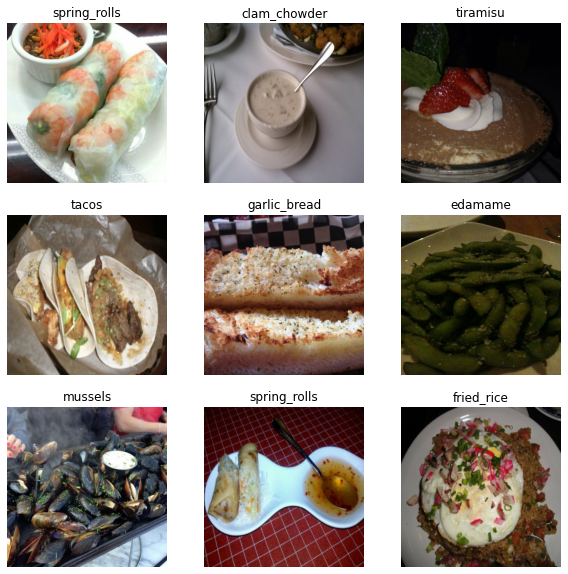

In [ ]:
data = image_dataset_from_directory(train_dir)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 5)
validation_dataset = validation_dataset.skip(validation_batches // 5)

print('Total number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Total number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Total number of validation batches: 632
Total number of test batches: 158


#Data Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Architecture

##Load MobileNetV2 Pretrained Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature, target = next(iter(train_dataset))
feature_batch = base_model(feature)
print(feature_batch.shape)

(32, 7, 7, 1280)


##Freeze Layer

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


##Create New Dense Layer

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)                  

x = layers.Dense(101, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x) 

model = tf.keras.Model(inputs, x) 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              131174

#Training Preparation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Training

In [ ]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[es_callback])

Epoch 1/100
2368/2368 [==============================] - 353s 148ms/step - loss: 3.8425 - accuracy: 0.2304 - val_loss: 2.4732 - val_accuracy: 0.4937
Epoch 2/100
2368/2368 [==============================] - 347s 146ms/step - loss: 2.8572 - accuracy: 0.3908 - val_loss: 2.1163 - val_accuracy: 0.5436
Epoch 3/100
2368/2368 [==============================] - 339s 143ms/step - loss: 2.5688 - accuracy: 0.4365 - val_loss: 1.9263 - val_accuracy: 0.5691
Epoch 4/100
2368/2368 [==============================] - 278s 117ms/step - loss: 2.3797 - accuracy: 0.4680 - val_loss: 1.8105 - val_accuracy: 0.5829
Epoch 5/100
2368/2368 [==============================] - 277s 117ms/step - loss: 2.2466 - accuracy: 0.4887 - val_loss: 1.7287 - val_accuracy: 0.5939
Epoch 6/100
2368/2368 [==============================] - 278s 117ms/step - loss: 2.1452 - accuracy: 0.5059 - val_loss: 1.6711 - val_accuracy: 0.6028
Epoch 7/100
2368/2368 [==============================] - 278s 117ms/step - loss: 2.0645 - accuracy: 0.5171

#Plot Loss and Accuracy

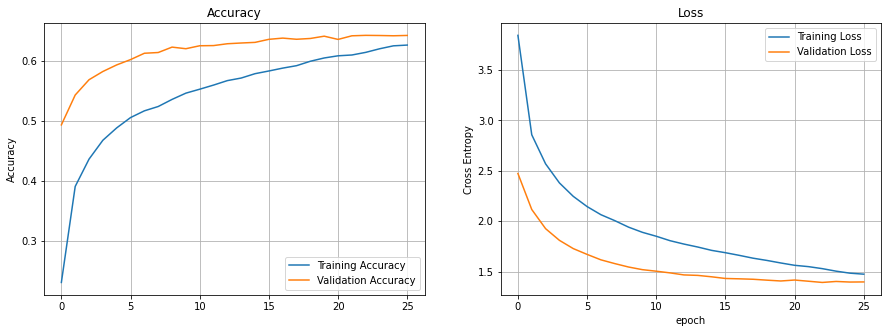

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

#Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              131174

In [ ]:
fine_tune_epochs = 100
total_epochs =  21 + fine_tune_epochs
print(total_epochs)

121


In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es_callback])

Epoch 26/121
2368/2368 [==============================] - 326s 135ms/step - loss: 1.3974 - accuracy: 0.6457 - val_loss: 1.3224 - val_accuracy: 0.6654
Epoch 27/121
2368/2368 [==============================] - 322s 136ms/step - loss: 1.3098 - accuracy: 0.6669 - val_loss: 1.2610 - val_accuracy: 0.6790
Epoch 28/121
2368/2368 [==============================] - 319s 135ms/step - loss: 1.2570 - accuracy: 0.6798 - val_loss: 1.2549 - val_accuracy: 0.6816
Epoch 29/121
2368/2368 [==============================] - 318s 134ms/step - loss: 1.2114 - accuracy: 0.6912 - val_loss: 1.2110 - val_accuracy: 0.6937
Epoch 30/121
2368/2368 [==============================] - 319s 134ms/step - loss: 1.1865 - accuracy: 0.6973 - val_loss: 1.2017 - val_accuracy: 0.6928
Epoch 31/121
2368/2368 [==============================] - 319s 134ms/step - loss: 1.1469 - accuracy: 0.7082 - val_loss: 1.1830 - val_accuracy: 0.7007
Epoch 32/121
2368/2368 [==============================] - 321s 135ms/step - loss: 1.1238 - accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

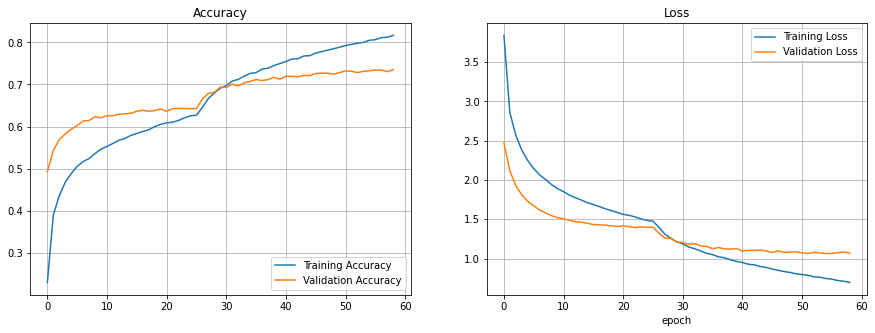

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

158/158 [==============================] - 14s 89ms/step - loss: 1.1195 - accuracy: 0.7352
Test accuracy : 0.7351661324501038


In [ ]:
tf.keras.models.save_model(model, '/content/gdrive/MyDrive/saved_model/model_with_regulerizer.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Convert to Tensorflow Lite

In [ ]:
tflite_model = tf.keras.models.load_model('/content/gdrive/MyDrive/saved_model/model_with_regulerizer.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("/content/gdrive/MyDrive/saved_model/model_regulerizer.tflite", "wb").write(tflite_save)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp6h4iyv0x/assets


16845152